<a href="https://colab.research.google.com/github/kurasaiteja/Whatsapp-Analysis/blob/master/Whatsapp_Group_Chat_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whatsapp Group Chat Data Analysis using python.

Hey there! This a project which would keep evolving with time.

A typical data science project would involve 5 steps. The first step is Data Collection. In this case Data collection involves

Opening Whatsapp group chat.
Go to Settings.
Click on Export Chat.
Click on without media.

In [1]:
!pip install emoji

In [4]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

UsageError: Line magic function `%` not found.


In [331]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 5853 (delta 85), reused 120 (delta 52), pack-reused 5667
Receiving objects: 100% (5853/5853), 107.06 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (3420/3420), done.
/content/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud
Processing /content/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post90+gbda4195-cp36-cp36m-linux_x86_64.whl size=338629 sha256=e7c5b557001a41bed132ad51d8cf139743900f57b440dee419f2f149348912d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-7tr9d_qb/wheels/f5/6c/dc/a8ba0219e200b2cda5078137dd0135059a3accd97f169528e8
Successfully built wordcloud
  Found existing installation: wordcloud 1.6.0.post90+gbda4195
    Uninstalling wordcloud-1.6.0.post90+gbd

# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}






In [5]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [6]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [7]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ')
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message


If you get a **Value Error** after running the below cell , it may be due to different format of date.

Try replacing %d-%m-%Y with %m-%d-%Y and replacing %d-%m-%y with %m-%d-%y and similarly for / too.

In [8]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")

In [9]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

Change file path in the below cell

<!doctype html><html lang="es" dir="ltr"><head><base href="https://accounts.google.com/"><script data-id="_gd" nonce="DuGvoaw9QSjpv48vI9TpHw">window.WIZ_global_data = {"Mo6CHc":-7848567195024959478,"OewCAd":"%.@.\"xsrf\",null,[\"\"]\n,\"AFoagUWCqZj9qzkDkJBeDVHrMyOcprZqxQ:1601894222592\"]\n","Qzxixc":"S335876379:1601894222577103","thykhd":"AKH95euat3a1df4ryhbTmZDCn8B97jSzexq_S_Oa18PJm8JP9Pq6PhWue8P54thql0S2KSzxGcGLzeFDY1kfs4s39v4YR0hApHLxCB4_XmQV07n-ECo\u003d","w2btAe":"%.@.null,null,\"\",false,null,null,true,false]\n"};</script><meta charset="utf-8"/><meta http-equiv="X-UA-Compatible" content="IE=edge"/><link rel="shortcut icon" href="//www.google.com/favicon.ico"/><noscript><meta http-equiv="refresh" content="0; url=https://accounts.google.com/ServiceLogin?continue=https%3A%2F%2Fmail.google.com%2Fmail%2F%3Fui%3D2%26ik%3D6469cab281%26attid%3D0.1%26permmsgid%3Dmsg-f%3A1679707722653388540%26th%3D174f8546373c4efc%26view%3Datt%26disp%3Dsafe%26sadnir%3D1&amp;rip=1&amp;nojavascript=1&amp;ser
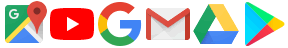

In [11]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'content/Saheco-Class-of-1981.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

In [14]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [15]:
df.head(2)

,Date,Time,Author,Message,emoji,urlcount


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      0 non-null      datetime64[ns]
 1   Time      0 non-null      object        
 2   Author    0 non-null      object        
 3   Message   0 non-null      object        
 4   emoji     0 non-null      object        
 5   urlcount  0 non-null      int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 0.0+ bytes


## Printing Participants

In [17]:
df.Author.unique()

array([], dtype=object)

**None** which is the first element in array indicates few messages which do not have authors like,


*   Group was created.
*   Teja was added and so on.



Let us remove the messages created by None

In [18]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      0 non-null      datetime64[ns]
 1   Time      0 non-null      object        
 2   Author    0 non-null      object        
 3   Message   0 non-null      object        
 4   emoji     0 non-null      object        
 5   urlcount  0 non-null      int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 0.0+ bytes


In [19]:
df.Author.unique()

array([], dtype=object)

We successfully removed None author.

# Group Wise Stats.

In [20]:
total_messages = df.shape[0]
print(total_messages)

0


Let us now find out the total Media Messages

In [345]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

0


In [346]:
emojis = sum(df['emoji'].str.len())
print(emojis)

6570


In [347]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [348]:
links = np.sum(df.urlcount)

In [349]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 34827
Media: 0
Emojis: 6570
Links: 88


## Let us Separate the media messages and text messages

In [350]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")|(df["Message"] == " You deleted this message.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [351]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34348 entries, 0 to 35088
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      34348 non-null  datetime64[ns]
 1   Time      34348 non-null  object        
 2   Author    34348 non-null  object        
 3   Message   34348 non-null  object        
 4   emoji     34348 non-null  object        
 5   urlcount  34348 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.8+ MB


It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [352]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [353]:
messages_df.head(2)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
0,2019-03-07,6:45 PM,Aakarsh Yelisetty,Arey,[],0,5,2,1
1,2019-03-07,6:45 PM,Aakarsh Yelisetty,Adhe chedham aa inka?,[],0,22,5,1


In [354]:
messages_df["emojicount"]= df['emoji'].str.len()

#Author wise stats

In [355]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(link_messages[link_messages['Author'] == l[i]]["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Aakarsh Yelisetty -
Messages Sent 5544
Words per message 4.681637806637807
Media Messages Sent 100
Emojis Sent 1369
Links Sent 35

Stats of Gowtham Vce -
Messages Sent 5979
Words per message 3.7991302893460444
Media Messages Sent 46
Emojis Sent 1817
Links Sent 1

Stats of Vishal Vce -
Messages Sent 9653
Words per message 4.3061224489795915
Media Messages Sent 64
Emojis Sent 1408
Links Sent 26

Stats of Sai Teja -
Messages Sent 7732
Words per message 4.942188308329023
Media Messages Sent 165
Emojis Sent 799
Links Sent 17

Stats of Manikanta -
Messages Sent 5440
Words per message 5.254044117647059
Media Messages Sent 71
Emojis Sent 1175
Links Sent 9



# Most used Emoji in Group

# Emoji Stats

### Unique emojis used in group

In [356]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

177


### Most used emoji

In [357]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 2682), ('🤣', 1431), ('\U0001f97a', 383), ('😒', 208), ('🔥', 79), ('🙄', 78), ('😞', 64), ('🤦🏻\u200d♂️', 61), ('\U0001f973', 61), ('🤕', 53), ('🤙🏻', 46), ('😮', 45), ('😪', 44), ('🙂', 44), ('😭', 43), ('😢', 43), ('🤧', 40), ('🤦🏻\u200d♂', 37), ('😅', 35), ('😨', 34), ('😕', 34), ('😔', 34), ('😏', 31), ('🙃', 29), ('😎', 29), ('😱', 28), ('\U0001f975', 26), ('🤥', 26), ('🤢', 23), ('🙏', 23), ('☹️', 23), ('💥', 23), ('\U0001f92f', 22), ('\U0001f928', 20), ('😖', 19), ('👏🏻', 18), ('😣', 18), ('😆', 18), ('😑', 17), ('🙏🏻', 17), ('😁', 16), ('😟', 16), ('🤷🏻\u200d♂️', 16), ('👍🏻', 16), ('😳', 15), ('🍃', 14), ('\U0001f974', 13), ('😲', 13), ('\U0001f929', 11), ('🍻', 11), ('\U0001f971', 11), ('😤', 10), ('🕺🏻', 10), ('\U0001f970', 10), ('😍', 10), ('😐', 9), ('😓', 9), ('😴', 9), ('🤔', 8), ('👀', 8), ('\U0001f92e', 8), ('👍', 8), ('\U0001f9d0', 8), ('🤷🏻\u200d♂', 8), ('😦', 8), ('\U0001f92d', 7), ('🤐', 7), ('😶', 7), ('😬', 7), ('😡', 7), ('👗', 7), ('😵', 7), ('🙁', 7), ('\U0001f9b8\u200d♂️', 7), ('💯', 7), ('🙆🏻\u200d♂', 6), ('😹',

In [358]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,2682
1,🤣,1431
2,🥺,383
3,😒,208
4,🔥,79
...,...,...
172,👋,1
173,😗,1
174,🍀,1
175,🖕🏻,1


We can see '😂 '   dominates the list.

### Emoji distribution visualisation

In [359]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [360]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Aakarsh Yelisetty


Emoji Distribution for Gowtham Vce


Emoji Distribution for Vishal Vce


Emoji Distribution for Sai Teja


Emoji Distribution for Manikanta


# Some more Stats

### **Day wise Distribution**

In [361]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [362]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

### **Number of messages as times move on**

In [363]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [364]:
date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

### **Chatter**

In [365]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

### **When are the group members most active?**

Text(0, 0.5, 'Time')

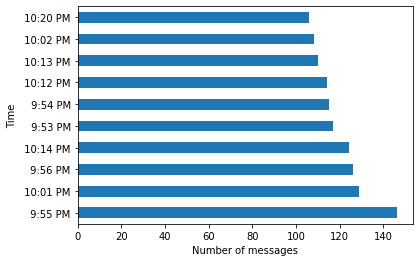

In [366]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

### **The most happening day was -**

2019-07-26    720
2020-06-26    457
2019-08-18    434
2020-04-06    432
2019-08-12    409
             ... 
2019-09-09      1
2019-11-03      1
2019-04-15      1
2019-04-28      1
2019-06-05      1
Name: Date, Length: 390, dtype: int64


Text(0, 0.5, 'Date')

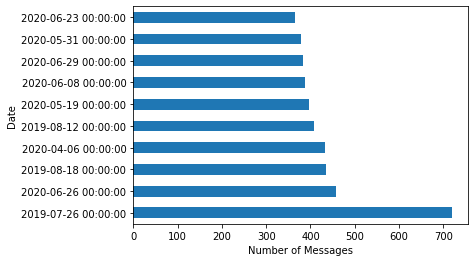

In [367]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### **The early bird**

### The Late Owl

### **Message Having Maximum number of words**

In [368]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2019-04-25 00:00:00
Time                                                      9:59 PM
Author                                          Aakarsh Yelisetty
Message          Hello IT III Year, Section A-B students,  Ple...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                 2704
Word_Count                                                    498
MessageCount                                                    1
emojicount                                                      0
Name: 1260, dtype: object

### **Word Cloud**

In [369]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 744871 words in all the messages.


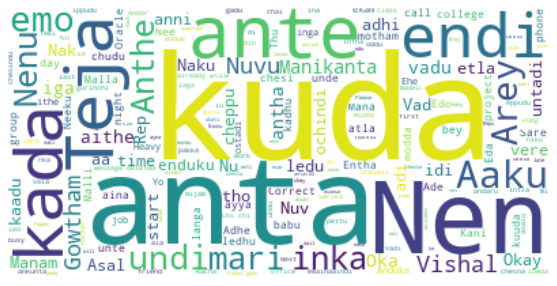

In [370]:
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

###**Author Wise Wordcloud**

In [371]:
# l = messages_df.Author.unique()
# for i in range(len(l)):
#   dummy_df = messages_df[messages_df['Author'] == l[i]]
#   text = " ".join(review for review in dummy_df.Message)
#   stopwords = set(STOPWORDS)
#   stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
#   # Generate a word cloud image
#   print('Author name',l[i])
#   wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
#   # Display the generated image:
#   # the matplotlib way:
  
#   plt.figure( figsize=(10,5))
#   plt.imshow(wordcloud, interpolation='bilinear')
#   plt.axis("off")
#   plt.show()

In [372]:
""

''